## Package Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

## Retrieve data from Dataset

In [19]:
data = pd.read_csv("./archive/data.csv")

## Dataset statistics

Top rows of the dataset

In [4]:
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
JoiningYear,4653.0,2015.062970,1.863377,2012.0,2013.0,2015.0,2017.0,2018.0
PaymentTier,4653.0,2.698259,0.561435,1.0,3.0,3.0,3.0,3.0
Age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
ExperienceInCurrentDomain,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
LeaveOrNot,4653.0,0.343864,0.475047,0.0,0.0,0.0,1.0,1.0


In [6]:
data.shape

(4653, 9)

In [7]:
data.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [20]:
duplicates = data.duplicated().sum()
print('Number of duplicate records:', duplicates)

Number of duplicate records: 1889
Shape after dropping duplicate records: (4653, 9)


<AxesSubplot:xlabel='Education', ylabel='count'>

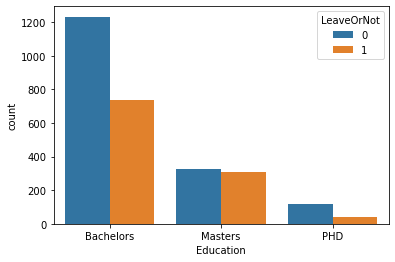

In [9]:
sns.countplot(data = data ,x='Education',hue='LeaveOrNot')

<AxesSubplot:xlabel='JoiningYear', ylabel='count'>

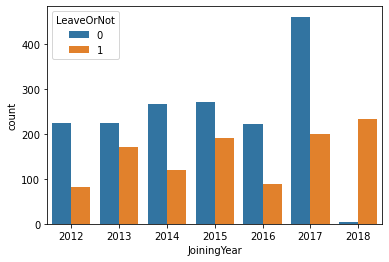

In [10]:
sns.countplot(data = data ,x='JoiningYear',hue='LeaveOrNot')

<AxesSubplot:xlabel='PaymentTier', ylabel='count'>

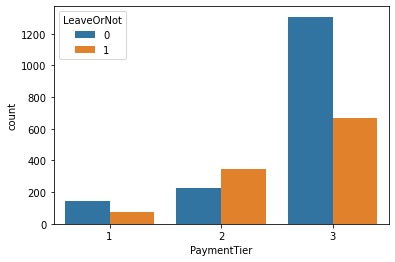

In [11]:
sns.countplot(data = data ,x='PaymentTier',hue='LeaveOrNot')

<AxesSubplot:xlabel='City', ylabel='count'>

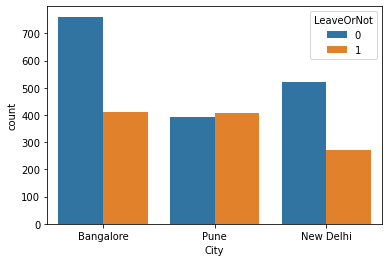

In [12]:
sns.countplot(data = data ,x='City',hue='LeaveOrNot')

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

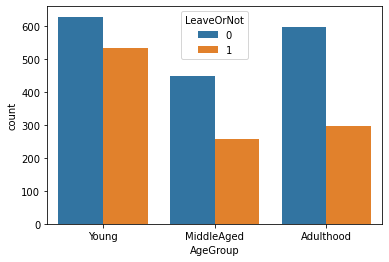

In [13]:
groups = ['Young', 'MiddleAged', 'Adulthood']
data['AgeGroup'] = pd.qcut(data['Age'], q=3, labels=groups)
sns.countplot(data = data, x='AgeGroup', hue='LeaveOrNot')

/tmp/ipykernel_75561/2043227787.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

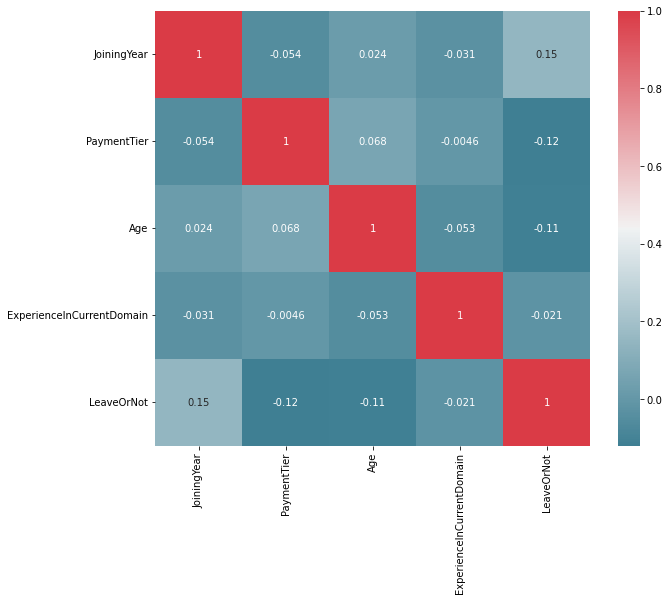

In [14]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax ,annot=True)

Age, PaymentTier and Joining Year are effect on leave or not decision for employee ("It's a small effect but it still effect")

In [15]:
fig = px.box(data, x="PaymentTier", y="ExperienceInCurrentDomain", color="Gender")
fig.update_traces(quartilemethod="exclusive")
fig.show()

##### **Does experience have an affect on Payment tier?**

In PaymentTier = 1, the experience of females is nearly the name like males and there are males with higher experience than females.

In PaymentTier = 2, the experience of females is nearly the name like males and there are females with higher experience than males.

In PaymentTier = 3, the average of females has more experience in domain than males.

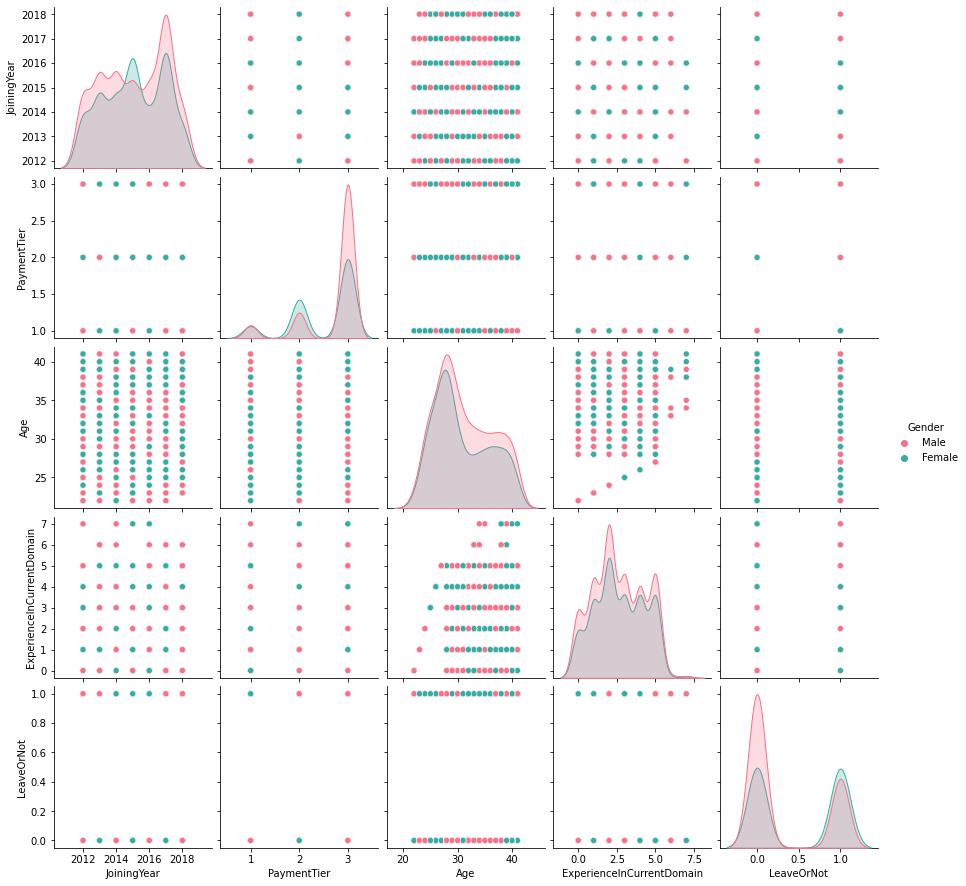

In [16]:
sns.pairplot(data = data , hue = "Gender" , palette = 'husl')

##### **Which employee is most likely to leave the company?**

* In terms of **education**, employees with **Masters degree**** are most likely to leave the company.

* Employees who joined in **recent year** are most likely to leave the company. Maybe they are not satisfied with thier salary or their department work culture.

* Employee from **Pune City** are most likely to leave. So, we should check this branch of the company.

* In terms of **Salary**, employee with **PaymentTier 3** are most likely to leave. They are very important for the company because of their level of experience, So company should offer a raise for those employees.

* **Female** employee are more likely to leave.

* Most of the employee who were **benched left** the company.

* As we analysed in **joining year** the employees with **less experience** are the one's who are leaving the company. The company can offer a raise in the salary.

* **Young** employees most likely to leave. The company should be a stable company and give them a raise in salary.


## Models


### Functions to train and analyse data

In [17]:
def train_and_analyze(model, X_train, y_train, X_test, y_test):
    # fitting the object
    model.fit(X_train, y_train)
    
    # finding the predicted valued
    y_pred = model.predict(X_test)

    # determine test accuracy
    test_data_accuracy = accuracy_score(y_pred, y_test)

    # F1_score = 2 * (P * R)/(P + R)
    #   P : Precision
    #   R : Recall of the model
    f1 = f1_score(y_test, y_pred)

    #   >> Accuracy vs F1-score
    # Accuracy is used when the True Positives and True negatives are more important 
    # while F1-score is used when the False Negatives and False Positives are crucial

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy * 100, "%")
    print('F1 Score: ', f1 * 100, "%")
    
    print()
    
    print("---- Confusion Matrix ----")
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print( classification_report(y_test, model.predict(X_test)) )
    


def hyperparameters(model, params, X, y):
    print(">> Find hyperparameters for a model")

    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params:", model.best_params_)

    return model.best_params_



def kfold(model, k, X, Y):
    print(">> k-fold cross-validation")
    
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X, Y, scoring="accuracy", cv=kf, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]